# Basic config

In [0]:
#Uploading dataset from GoogleDrive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#To go to your drive’s main directory
cd /content/gdrive/My Drive/

/content/gdrive/My Drive


In [0]:
img_dir = '/content/gdrive/My Drive/dataset/'
print(img_dir)

/content/gdrive/My Drive/dataset/


In [0]:
cd '/content/gdrive/My Drive/dataset/'

/content/gdrive/My Drive/dataset


# Data preprocessing-Split folders

In [0]:
"""Splits a folder with the given format:
    class1/
        img1.jpg
        img2.jpg
        ...
    class2/
        imgWhatever.jpg
        ...
    ...
into this resulting format:
    train/
        class1/
            img1.jpg
            ...
        class2/
            imga.jpg
            ...
    val/
        class1/
            img2.jpg
            ...
        class2/
            imgb.jpg
            ...
    test/
        class1/
            img3.jpg
            ...
        class2/
            imgc.jpg
            ...
"""

import pathlib
import random
import shutil
from os import path

try:
    from tqdm import tqdm

    tqdm_is_installed = True
except ImportError:
    tqdm_is_installed = False


def list_dirs(directory):
    """Returns all directories in a given directory
    """
    return [f for f in pathlib.Path(directory).iterdir() if f.is_dir()]


def list_files(directory):
    """Returns all files in a given directory
    """
    return [
        f
        for f in pathlib.Path(directory).iterdir()
        if f.is_file() and not f.name.startswith(".")
    ]


def ratio(input, output="output", seed=1337, ratio=(0.8, 0.1, 0.1)):
    # make up for some impression
    assert round(sum(ratio), 5) == 1
    assert len(ratio) in (2, 3)

    if tqdm_is_installed:
        prog_bar = tqdm(desc=f"Copying files", unit=" files")

    for class_dir in list_dirs(input):
        split_class_dir_ratio(
            class_dir, output, ratio, seed, prog_bar if tqdm_is_installed else None
        )

    if tqdm_is_installed:
        prog_bar.close()


def fixed(input, output="output", seed=1337, fixed=(100, 100), oversample=False):
    # make sure its reproducible
    if isinstance(fixed, int):
        fixed = fixed

    assert len(fixed) in (1, 2)

    if tqdm_is_installed:
        prog_bar = tqdm(desc=f"Copying files", unit=" files")

    dirs = list_dirs(input)
    lens = []
    for class_dir in dirs:
        lens.append(
            split_class_dir_fixed(
                class_dir, output, fixed, seed, prog_bar if tqdm_is_installed else None
            )
        )

    if tqdm_is_installed:
        prog_bar.close()

    if not oversample:
        return

    max_len = max(lens)

    iteration = zip(lens, dirs)

    if tqdm_is_installed:
        iteration = tqdm(iteration, desc="Oversampling", unit=" classes")

    for length, class_dir in iteration:
        class_name = path.split(class_dir)[1]
        full_path = path.join(output, "train", class_name)
        train_files = list_files(full_path)
        for i in range(max_len - length):
            f_orig = random.choice(train_files)
            new_name = f_orig.stem + "_" + str(i) + f_orig.suffix
            f_dest = f_orig.with_name(new_name)
            shutil.copy2(f_orig, f_dest)


def setup_files(class_dir, seed):
    """Returns shuffled files
    """
    # make sure its reproducible
    random.seed(seed)

    files = list_files(class_dir)

    files.sort()
    random.shuffle(files)
    return files


def split_class_dir_fixed(class_dir, output, fixed, seed, prog_bar):
    """Splits one very class folder
    """
    files = setup_files(class_dir, seed)

    if not len(files) > sum(fixed):
        raise ValueError(
            f'The number of samples in class "{class_dir.stem}" are too few. There are only {len(files)} samples available but your fixed parameter {fixed} requires at least {sum(fixed)} files. You may want to split your classes by ratio.'
        )

    split_train = len(files) - sum(fixed)
    split_val = split_train + fixed[0]

    li = split_files(files, split_train, split_val, len(fixed) == 2)
    copy_files(li, class_dir, output, prog_bar)
    return len(files)


def split_class_dir_ratio(class_dir, output, ratio, seed, prog_bar):
    """Splits one very class folder
    """
    files = setup_files(class_dir, seed)

    split_train = int(ratio[0] * len(files))
    split_val = split_train + int(ratio[1] * len(files))

    li = split_files(files, split_train, split_val, len(ratio) == 3)
    copy_files(li, class_dir, output, prog_bar)


def split_files(files, split_train, split_val, use_test):
    """Splits the files along the provided indices
    """
    files_train = files[:split_train]
    files_val = files[split_train:split_val] if use_test else files[split_train:]

    li = [(files_train, "train"), (files_val, "val")]

    # optional test folder
    if use_test:
        files_test = files[split_val:]
        li.append((files_test, "test"))
    return li


def copy_files(files_type, class_dir, output, prog_bar):
    """Copies the files from the input folder to the output folder
    """
    # get the last part within the file
    class_name = path.split(class_dir)[1]
    for (files, folder_type) in files_type:
        full_path = path.join(output, folder_type, class_name)

        pathlib.Path(full_path).mkdir(parents=True, exist_ok=True)
        for f in files:
            if not prog_bar is None:
                prog_bar.update()
            shutil.copy2(f, full_path)

In [0]:
#==========================UNCOMMENT FOR SPLITING=============================================
ratio(img_dir, output="output", seed=1337, ratio=(.7, .15, .15)) # default values
#=================================================================================================

# Import libraries and Prepare Data

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import RMSprop, SGD
from keras import backend as K

import keras

import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy

In [0]:
#For debug ResourceExhaustedError: OOM when allocating tensor with shape
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [0]:
#Prepare Data
img_width, img_height = 200, 200

output_dir = img_dir + 'output/'

train_data_dir = os.path.join(output_dir, 'train')
print(train_data_dir)
validation_data_dir = os.path.join(output_dir, 'val')
test_data_dir = os.path.join(output_dir, 'test')
epochs = 4
batch_size = 16
numclasses = 6

/content/gdrive/My Drive/dataset/output/train


# Data augmentation

In [0]:
# dataset
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    #shear_range=0.2,
    vertical_flip=False,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')



Found 1419 images belonging to 6 classes.
Found 301 images belonging to 6 classes.
Found 310 images belonging to 6 classes.


In [0]:
nb_train_samples = 1419 
nb_validation_samples = 301
nb_test_samples = 310

# Create the base model from the pre-trained convnets

In [0]:
#Model
#if channel is first set input shape => (3, 200, 200) else (200, 200, 3)
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [0]:
base_model = None
base_model = keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step


**Freeze Convolutional base**

In [0]:
# It is important to freeze the convolutional base before you compile and train the model. 
#Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. 
#MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.

In [0]:
base_model.trainable = False

In [0]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
print(base_model.output_shape[1:])

(7, 7, 2048)


In [0]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:])) #Flattens the input. Does not affect the batch size.
for i in range(2):
  top_model.add(Dense(4096, activation='relu')) #Apply a Dense layer to convert these features into a single prediction per image. 
  top_model.add(Dropout(0.5)) #Dropout consists in randomly setting a fraction rate of input units to 0.5 at each update during training time, which helps prevent overfitting.
top_model.add(Dense(numclasses, activation='softmax'))



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
top_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              411045888 
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 24582     
Total params: 427,851,782
Trainable params: 427,851,782
Non-trainable params: 0
________________________________________

In [0]:
#https://keras.io/getting-started/functional-api-guide/
model = None
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

**Compile the model**

In [0]:
#model = resnet50tl(input_shape, numclasses, 'softmax')
lr = 1e-5
decay = 1e-7 #0.0
optimizer = RMSprop(lr=lr, decay=decay)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Display model/network

In [0]:
from keras.utils.vis_utils import plot_model

#plot_model(model, show_shapes=True, show_layer_names = True)
from IPython.display import Image

#Uncomment for visualisation

#Image(filename='model.png')

# Train Model

In [0]:
#Train
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/4
88/88 [==============================] - 586s 7s/step - loss: 2.3531 - acc: 0.3912 - val_loss: 0.8877 - val_acc: 0.7361
Epoch 2/4
88/88 [==============================] - 23s 257ms/step - loss: 1.3065 - acc: 0.6244 - val_loss: 0.6114 - val_acc: 0.8105
Epoch 3/4
88/88 [==============================] - 23s 256ms/step - loss: 0.9651 - acc: 0.7089 - val_loss: 0.7500 - val_acc: 0.7965
Epoch 4/4
88/88 [==============================] - 23s 257ms/step - loss: 0.7739 - acc: 0.7809 - val_loss: 0.4773 - val_acc: 0.8491


# Performance and Evaluation

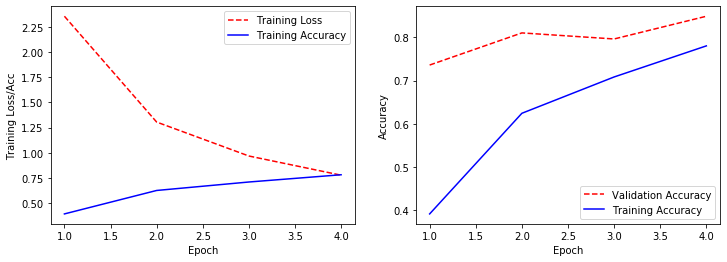

In [0]:
# Get training and test loss histories - Learning curves
training_loss = history.history['loss']
training_acc = history.history['acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

fig=plt.figure(figsize=(12, 4))
# Visualize loss history
fig.add_subplot(121)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, training_acc, 'b-')
plt.legend(['Training Loss', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Training Loss/Acc')

# Get training and test loss histories
val_acc = history.history['val_acc']
training_acc = history.history['acc']

# Create count of the number of epochs
epoch_count = range(1, len(val_acc) + 1)

# Visualize loss history
fig.add_subplot(122)
plt.plot(epoch_count, val_acc, 'r--')
plt.plot(epoch_count, training_acc, 'b-')
plt.legend(['Validation Accuracy', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [0]:
saveweight =  'celebriytag_weight_transfer.h5'
model.save_weights(saveweight)

In [0]:
model.load_weights(saveweight)

In [0]:
#Evaluate the model on test set
print(model.evaluate_generator(test_generator,steps= (nb_test_samples // batch_size), verbose = 1))

19/19 [==============================] - 115s 6s/step
[0.6179906867052379, 0.8519736842105263]


In [0]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import numpy as np
import sklearn.metrics as metrics

In [0]:
test_generator.reset()

In [61]:
Y_pred = model.predict_generator(test_generator)
classes = test_generator.classes[test_generator.index_array]
y_pred = np.argmax(Y_pred, axis=-1)
sum(y_pred==classes)/10000


from sklearn.metrics import confusion_matrix
confusion_matrix(test_generator.classes[test_generator.index_array],y_pred)

array([[60,  0,  0,  0,  0,  1],
       [ 0, 44,  0,  0,  0,  0],
       [ 0,  0, 59,  0,  1,  0],
       [ 0,  0,  2, 65,  2,  0],
       [ 0,  0,  1,  3, 43,  0],
       [ 2,  6,  3,  0,  6, 12]])

In [62]:
predicted_classes = numpy.argmax(Y_pred, axis=1)

report = metrics.classification_report(classes, predicted_classes, target_names = ['aaron_diaz',  'aaron_tippin',  'aarti_chabria',  'abbey_clancy',  'abby_elliott', 'uknown'])
print('\nClassification Report: \n')
print(report)


Classification Report: 

               precision    recall  f1-score   support

   aaron_diaz       0.97      0.98      0.98        61
 aaron_tippin       0.88      1.00      0.94        44
aarti_chabria       0.91      0.98      0.94        60
 abbey_clancy       0.96      0.94      0.95        69
 abby_elliott       0.83      0.91      0.87        47
       uknown       0.92      0.41      0.57        29

     accuracy                           0.91       310
    macro avg       0.91      0.87      0.87       310
 weighted avg       0.92      0.91      0.90       310



# Fine tuning

In [0]:
#UnFreeze all the layers of base_model to train it after 5 epochs 
base_model.trainable = True

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))


# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable =  False


Number of layers in the base model:  175


In [0]:
model2 = None
model2 = Model(inputs=base_model.input, outputs=top_model(base_model.output))

**Compile the model**

In [0]:
lr = 1e-5
decay = 1e-7 #0.0
optimizer = RMSprop(lr=lr, decay=decay)
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [0]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

# Continue training the model

In [0]:
#Train no2
fine_tune_epochs = 12
total_epochs =  epochs + fine_tune_epochs

history = model2.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=total_epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/16
88/88 [==============================] - 28s 317ms/step - loss: 0.6588 - acc: 0.8154 - val_loss: 0.5815 - val_acc: 0.8368
Epoch 2/16
88/88 [==============================] - 23s 258ms/step - loss: 0.4765 - acc: 0.8708 - val_loss: 0.4904 - val_acc: 0.8632
Epoch 3/16
88/88 [==============================] - 23s 257ms/step - loss: 0.4405 - acc: 0.8771 - val_loss: 0.6037 - val_acc: 0.8702
Epoch 4/16
88/88 [==============================] - 23s 259ms/step - loss: 0.3942 - acc: 0.8800 - val_loss: 0.5415 - val_acc: 0.8632
Epoch 5/16
88/88 [==============================] - 23s 259ms/step - loss: 0.3063 - acc: 0.9113 - val_loss: 0.4588 - val_acc: 0.8877
Epoch 6/16
88/88 [==============================] - 23s 256ms/step - loss: 0.2574 - acc: 0.9268 - val_loss: 0.5448 - val_acc: 0.8772
Epoch 7/16
88/88 [==============================] - 23s 257ms/step - loss: 0.2434 - acc: 0.9318 - val_loss: 0.5549 - val_acc: 0.8737
Epoch 8/16
88/88 [==============================] - 23s 256ms/step - 

# Performance and Evaluation after fine tuning

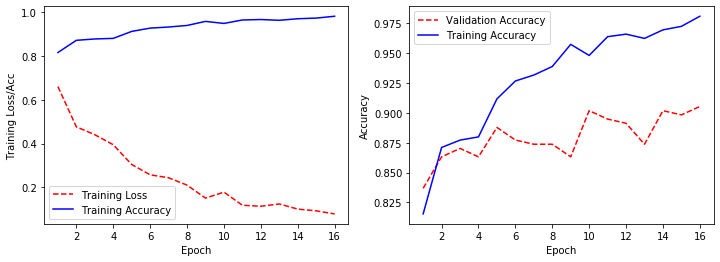

In [0]:
# Get training and test loss histories
training_loss = history.history['loss']
training_acc = history.history['acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

fig=plt.figure(figsize=(12, 4))
# Visualize loss history
fig.add_subplot(121)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, training_acc, 'b-')
plt.legend(['Training Loss', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Training Loss/Acc')

# Get training and test loss histories
val_acc = history.history['val_acc']
training_acc = history.history['acc']

# Create count of the number of epochs
epoch_count = range(1, len(val_acc) + 1)

# Visualize loss history
fig.add_subplot(122)
plt.plot(epoch_count, val_acc, 'r--')
plt.plot(epoch_count, training_acc, 'b-')
plt.legend(['Validation Accuracy', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [0]:
test_generator.reset()

Y_pred2 = model2.predict_generator(test_generator)
classes = test_generator.classes[test_generator.index_array]
y_pred2 = np.argmax(Y_pred2, axis=-1)
sum(y_pred2==classes)/10000


from sklearn.metrics import confusion_matrix
confusion_matrix(test_generator.classes[test_generator.index_array],y_pred2)

array([[60,  0,  0,  0,  0,  1],
       [ 0, 44,  0,  0,  0,  0],
       [ 0,  0, 59,  0,  1,  0],
       [ 0,  0,  2, 65,  2,  0],
       [ 0,  0,  1,  3, 43,  0],
       [ 2,  6,  3,  0,  6, 12]])

In [0]:
predicted_classes2 = numpy.argmax(Y_pred2, axis=1)

report = metrics.classification_report(classes, predicted_classes2, target_names = ['aaron_diaz',  'aaron_tippin',  'aarti_chabria',  'abbey_clancy',  'abby_elliott', 'uknown'])
print('\nClassification Report: \n')
print(report)


Classification Report: 

               precision    recall  f1-score   support

   aaron_diaz       0.97      0.98      0.98        61
 aaron_tippin       0.88      1.00      0.94        44
aarti_chabria       0.91      0.98      0.94        60
 abbey_clancy       0.96      0.94      0.95        69
 abby_elliott       0.83      0.91      0.87        47
       uknown       0.92      0.41      0.57        29

     accuracy                           0.91       310
    macro avg       0.91      0.87      0.87       310
 weighted avg       0.92      0.91      0.90       310



In [0]:
saveweight2 =  'celebriytag_weight_transfer2.h5'
model2.save_weights(saveweight2)

In [0]:
model2.load_weights(saveweight2)

In [0]:
#Evaluate the model on test set
print(model2.evaluate_generator(test_generator,steps= (nb_test_samples // batch_size), verbose = 1))

19/19 [==============================] - 10s 518ms/step
[1.0348970738110725, 0.9111842105263158]


# Evaluation per image

In [0]:
#Evaluation
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO
import cv2
import requests
import os

In [0]:
labels = ['aaron_diaz',  'aaron_tippin',  'aarti_chabria',  'abbey_clancy',  'abby_elliott', 'uknown']

/content/gdrive/My Drive/dataset/output/test/aaron_tippin/


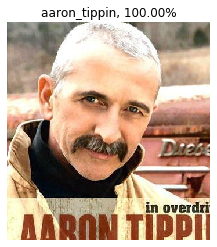

In [0]:
test_imgs = ['0311_01.jpg']

new_validation_data_dir = '/content/gdrive/My Drive/dataset/output/test/aaron_tippin/'

print(new_validation_data_dir)

for test in test_imgs:
    test_img = os.path.join(new_validation_data_dir, test)
    img = image.load_img(test_img, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    classes = model.predict(x)
    result = np.squeeze(classes)
    result_indices = np.argmax(result)
    
    img = cv2.imread(test_img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.title("{}, {:.2f}%".format(labels[result_indices], result[result_indices]*100))
    plt.imshow(img)

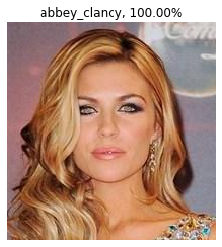

In [0]:
test_imgs = ['0058_01.jpg']

new_validation_data_dir = '/content/gdrive/My Drive/dataset/output/test/abbey_clancy/'

for test in test_imgs:
    test_img = os.path.join(new_validation_data_dir, test)
    img = image.load_img(test_img, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    classes = model.predict(x)
    result = np.squeeze(classes)
    result_indices = np.argmax(result)
    
    img = cv2.imread(test_img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.title("{}, {:.2f}%".format(labels[result_indices], result[result_indices]*100))
    plt.imshow(img)

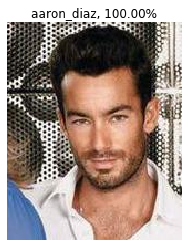

In [0]:
test_imgs = ['0081_01.jpg']

new_validation_data_dir = '/content/gdrive/My Drive/dataset/output/test/aaron_diaz/'

for test in test_imgs:
    test_img = os.path.join(new_validation_data_dir, test)
    img = image.load_img(test_img, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    classes = model.predict(x)
    result = np.squeeze(classes)
    result_indices = np.argmax(result)
    
    img = cv2.imread(test_img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.title("{}, {:.2f}%".format(labels[result_indices], result[result_indices]*100))
    plt.imshow(img)

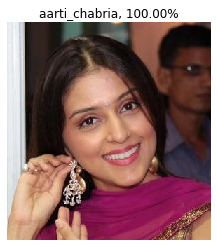

In [0]:
test_imgs = ['0205_02.jpg']

new_validation_data_dir = '/content/gdrive/My Drive/dataset/output/test/aarti_chabria/'

for test in test_imgs:
    test_img = os.path.join(new_validation_data_dir, test)
    img = image.load_img(test_img, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    classes = model.predict(x)
    result = np.squeeze(classes)
    result_indices = np.argmax(result)
    
    img = cv2.imread(test_img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.title("{}, {:.2f}%".format(labels[result_indices], result[result_indices]*100))
    plt.imshow(img)

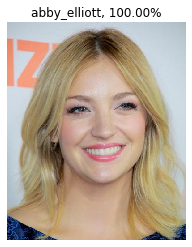

In [0]:
test_imgs = ['0037_01.jpg']

new_validation_data_dir = '/content/gdrive/My Drive/dataset/output/test/abby_elliott/'

for test in test_imgs:
    test_img = os.path.join(new_validation_data_dir, test)
    img = image.load_img(test_img, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    classes = model.predict(x)
    result = np.squeeze(classes)
    result_indices = np.argmax(result)
    
    img = cv2.imread(test_img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.title("{}, {:.2f}%".format(labels[result_indices], result[result_indices]*100))
    plt.imshow(img)

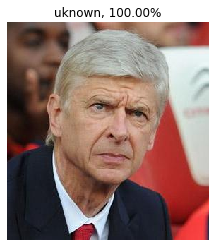

In [0]:
test_imgs = ['0027_03.jpg']

new_validation_data_dir = '/content/gdrive/My Drive/dataset/output/test/unkown/'

for test in test_imgs:
    test_img = os.path.join(new_validation_data_dir, test)
    img = image.load_img(test_img, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    classes = model.predict(x)
    result = np.squeeze(classes)
    result_indices = np.argmax(result)
    
    img = cv2.imread(test_img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.title("{}, {:.2f}%".format(labels[result_indices], result[result_indices]*100))
    plt.imshow(img)